In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from pprint import pprint 

In [92]:
train_df = pd.read_csv("data/train.csv")
features_df = pd.read_csv("data/features.csv")
stores_df = pd.read_csv("data/stores.csv")
test_df = pd.read_csv("data/test.csv")

In [93]:
train_df = (train_df
            .merge(features_df, how='left', indicator='indicator_column')
            .merge(stores_df, how='left'))
train_df.drop(columns=['indicator_column'], axis=1, inplace=True)

In [94]:
train_df = train_df.loc[train_df['Weekly_Sales'] > 0] #outliers

train_df.fillna(0, inplace=True)
train_df['Total_MarkDown'] = train_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1).astype(float)

In [95]:
train_df.isna().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Type              0
Size              0
Total_MarkDown    0
dtype: int64

In [96]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           420212 non-null  int64  
 1   Dept            420212 non-null  int64  
 2   Date            420212 non-null  object 
 3   Weekly_Sales    420212 non-null  float64
 4   IsHoliday       420212 non-null  bool   
 5   Temperature     420212 non-null  float64
 6   Fuel_Price      420212 non-null  float64
 7   MarkDown1       420212 non-null  float64
 8   MarkDown2       420212 non-null  float64
 9   MarkDown3       420212 non-null  float64
 10  MarkDown4       420212 non-null  float64
 11  MarkDown5       420212 non-null  float64
 12  CPI             420212 non-null  float64
 13  Unemployment    420212 non-null  float64
 14  Type            420212 non-null  object 
 15  Size            420212 non-null  int64  
 16  Total_MarkDown  420212 non-null  float64
dtypes: bool(1)

In [97]:
times_without_markdowns = [train_df['Date'][i] for i in range(40, 91)]
times_with_markdowns = [train_df['Date'][i] for i in range(92, 143)]

In [98]:
print(train_df['Date'].unique().tolist())

['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25', '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20', '2011-05-27', '2011-06-03', '2011-06-10', '2011

In [99]:
# data with markdowns period
print(train_df['Date'].unique().tolist().index('2011-11-11'))
print(train_df['Date'].unique().tolist().index('2012-10-26'))

92
142


In [100]:
# data without markdowns period
print(train_df['Date'].unique().tolist().index('2010-11-12'))
print(train_df['Date'].unique().tolist().index('2011-10-28'))

40
90


In [101]:
data_without_markdown = train_df[train_df['Date'].isin(times_without_markdowns)]
data_with_markdown = train_df[train_df['Date'].isin(times_with_markdowns)]

# Testing Normality Assumption

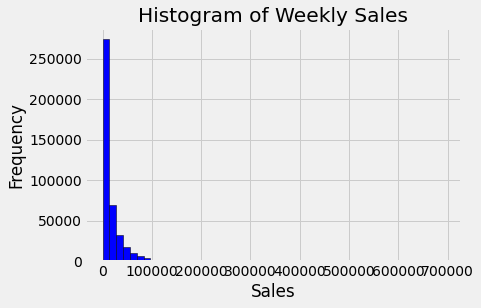

In [102]:
plt.hist(train_df['Weekly_Sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

### BoxCox transformation

In [103]:
train_df['boxcox_sales'], _ = boxcox(train_df['Weekly_Sales'])

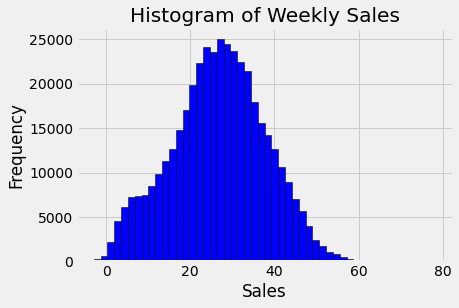

In [104]:
plt.hist(train_df['boxcox_sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Markdowns 

In [105]:
# Split data into two groups: days with markdowns and days without markdowns
sales_with_markdown = data_with_markdown['Weekly_Sales'] # Nov 11 to Oct 26 [2012]
sales_without_markdown = data_without_markdown['Weekly_Sales'] # Nov 12 to Oct 28 [2011]

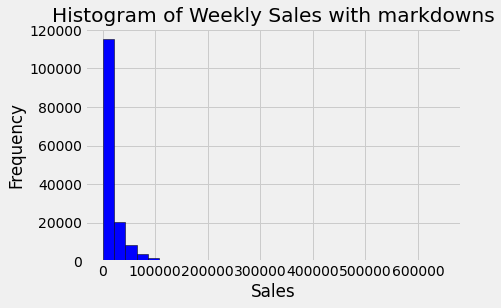

In [106]:
plt.hist(sales_with_markdown, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales with markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

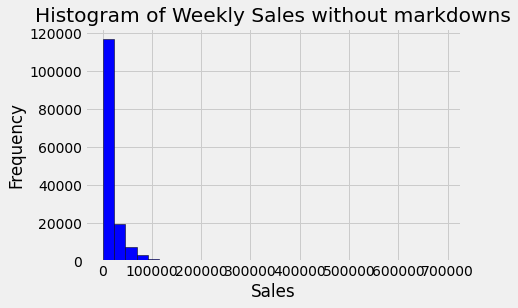

In [107]:
plt.hist(sales_without_markdown, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales without markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [108]:
print(sales_with_markdown.shape)
print(sales_without_markdown.shape)

(150929,)
(149535,)


In [109]:
print(sales_with_markdown.mean())
print(sales_without_markdown.mean())

16231.116040721136
16021.836361788208


In [110]:
# Assuming you've already computed the descriptives as:
stats_without_markdowns = data_without_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()
stats_with_markdowns = data_with_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()

# Compute the differences in means:
difference_in_means = stats_with_markdowns.loc['mean'] - stats_without_markdowns.loc['mean']

print("Difference in Means (With Markdowns - Without Markdowns):\n")
print(difference_in_means)

Difference in Means (With Markdowns - Without Markdowns):

Temperature     1.535219
Fuel_Price      0.160912
CPI             4.436657
Unemployment   -0.745140
Name: mean, dtype: float64


--- 

# Clustering Stores

In [111]:
df_clustering_stores = data_with_markdown.groupby('Store').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    "Total_MarkDown": "mean"
}).reset_index()

In [112]:
clusters_range = range(2, 15)

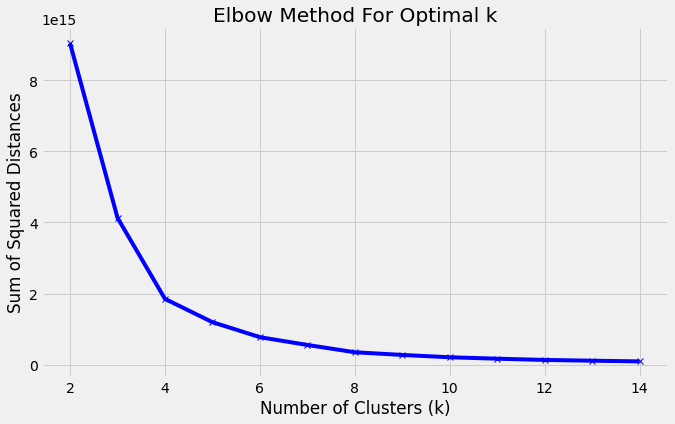

In [113]:
# Use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster center
sum_of_squared_distances = []

for k in clusters_range:
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(df_clustering_stores)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(clusters_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2, the silhouette score is 0.632
For n_clusters = 3, the silhouette score is 0.588
For n_clusters = 4, the silhouette score is 0.624
For n_clusters = 5, the silhouette score is 0.617
For n_clusters = 6, the silhouette score is 0.625
For n_clusters = 7, the silhouette score is 0.640
For n_clusters = 8, the silhouette score is 0.651
For n_clusters = 9, the silhouette score is 0.627
For n_clusters = 10, the silhouette score is 0.641
For n_clusters = 11, the silhouette score is 0.619
For n_clusters = 12, the silhouette score is 0.599
For n_clusters = 13, the silhouette score is 0.597
For n_clusters = 14, the silhouette score is 0.612


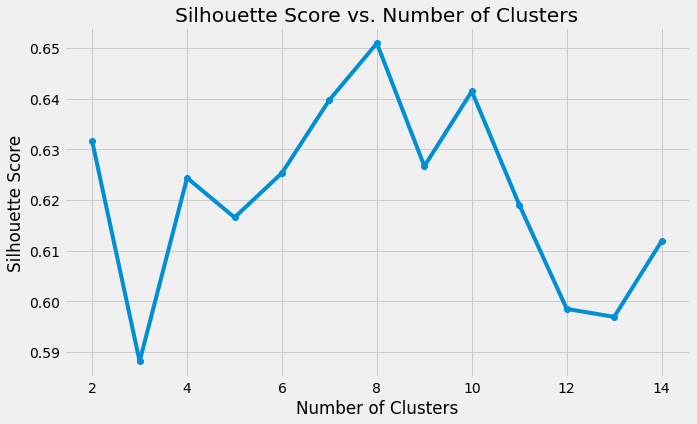

In [114]:
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in clusters_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(df_clustering_stores)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    silhouette_avg = silhouette_score(df_clustering_stores, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")


plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))

# Plot silhouette scores
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

In [115]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering_stores)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
df_clustering_stores['Cluster'] = kmeans.labels_

In [116]:
X_scaled.shape

(45, 7)

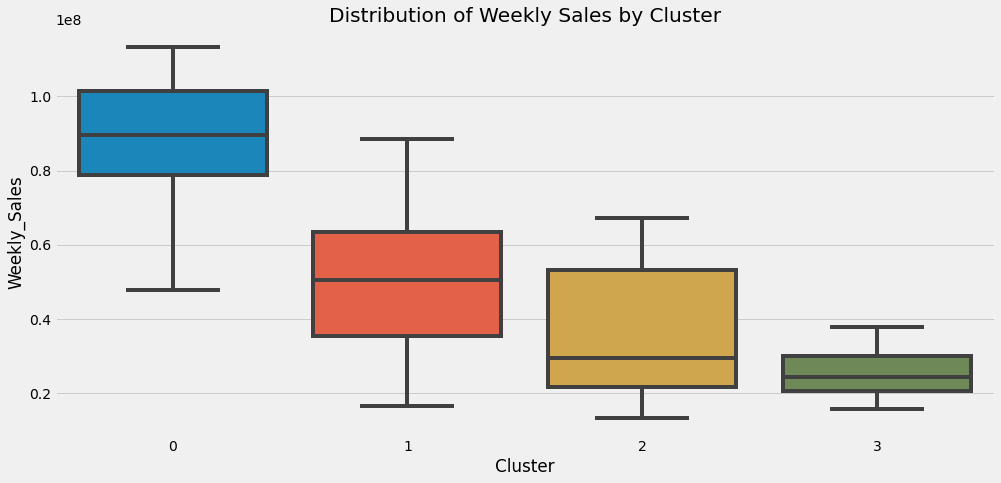

In [117]:
# Visualization for the distribution of Weekly Sales across clusters
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 7))
sns.boxplot(x='Cluster', y='Weekly_Sales', data=df_clustering_stores)
plt.title('Distribution of Weekly Sales by Cluster')
plt.show()

In [118]:
details = {}
for i in range(4):
    details[str(i)] = {}
    details[str(i)]["Stores"] = df_clustering_stores[df_clustering_stores["Cluster"] == i]["Store"].unique()
    details[str(i)]["No. of stores"] = df_clustering_stores[df_clustering_stores["Cluster"] == i]["Store"].nunique()
details["Total_stores"] = df_clustering_stores["Store"].nunique()

In [119]:
pprint(details)

{'0': {'No. of stores': 12,
       'Stores': array([ 1,  2,  4,  6,  8, 10, 11, 13, 14, 20, 31, 39], dtype=int64)},
 '1': {'No. of stores': 20,
       'Stores': array([ 7, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 29, 32, 34, 35, 40,
       41, 44, 45], dtype=int64)},
 '2': {'No. of stores': 5, 'Stores': array([12, 28, 33, 38, 42], dtype=int64)},
 '3': {'No. of stores': 8,
       'Stores': array([ 3,  5,  9, 21, 30, 36, 37, 43], dtype=int64)},
 'Total_stores': 45}


In [120]:
cluster_summary = df_clustering_stores.drop("Store", axis=1).groupby('Cluster').mean().reset_index()

In [121]:
cluster_summary

,Cluster,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Total_MarkDown
0,0,8.836126e+07,64.487346,3.572184,195.965860,6.650896,26254.435720
1,1,5.005106e+07,51.716210,3.702179,155.663201,7.440538,18413.127189
2,2,3.706061e+07,71.007034,3.949605,130.672606,9.977944,11538.287807
3,3,2.538583e+07,68.734989,3.494567,220.687966,6.924297,6503.236798


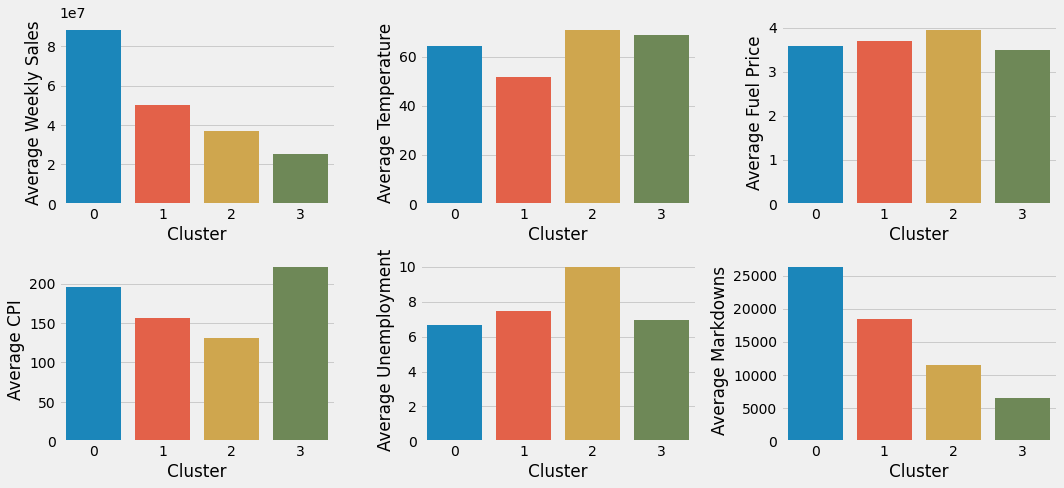

In [122]:
# Create a list of the features to be plotted along with their respective titles and y-labels
features = [
    ('Weekly_Sales','Average Weekly Sales'),
    ('Temperature', 'Average Temperature'),
    ('Fuel_Price', 'Average Fuel Price'),
    ('CPI', 'Average CPI'),
    ('Unemployment', 'Average Unemployment'), 
    ("Total_MarkDown", 'Average Markdowns')
]
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 7))
# Loop through the features list and plot each feature in a subplot
for i, (feature, ylabel) in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Cluster', y=feature, data=cluster_summary)
    # plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Cluster')

plt.tight_layout()
plt.show()

# Clustering Departments

In [123]:
df_clustering_depts = data_with_markdown.groupby('Dept').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    "Total_MarkDown": "mean"
}).reset_index()

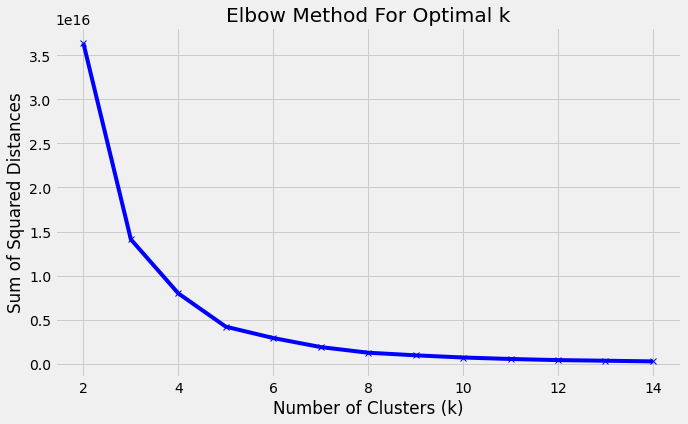

In [124]:
# Use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster center
sum_of_squared_distances = []

for k in clusters_range:
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(df_clustering_depts)
    sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(10,6))
plt.plot(clusters_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2, the silhouette score is 0.718
For n_clusters = 3, the silhouette score is 0.663
For n_clusters = 4, the silhouette score is 0.654
For n_clusters = 5, the silhouette score is 0.647
For n_clusters = 6, the silhouette score is 0.644
For n_clusters = 7, the silhouette score is 0.627
For n_clusters = 8, the silhouette score is 0.619
For n_clusters = 9, the silhouette score is 0.617
For n_clusters = 10, the silhouette score is 0.626
For n_clusters = 11, the silhouette score is 0.618
For n_clusters = 12, the silhouette score is 0.583
For n_clusters = 13, the silhouette score is 0.585
For n_clusters = 14, the silhouette score is 0.578


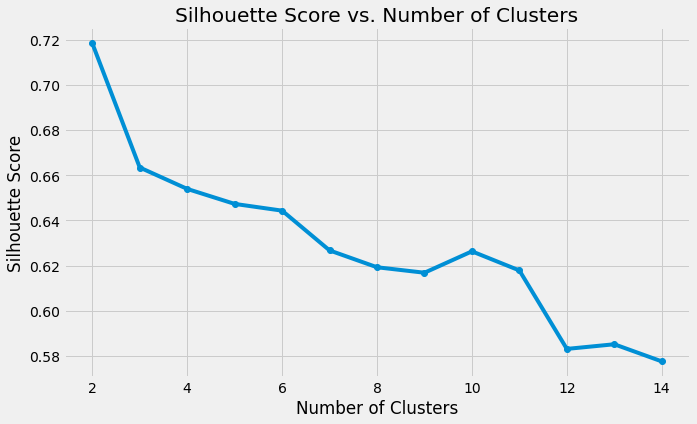

In [125]:
silhouette_scores = []

# Calculate silhouette scores for different numbers of clusters
for n_clusters in clusters_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(df_clustering_depts)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    silhouette_avg = silhouette_score(df_clustering_depts, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")


plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))

# Plot silhouette scores
plt.plot(clusters_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.show()

In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering_depts)

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)
df_clustering_depts['Cluster'] = kmeans.labels_

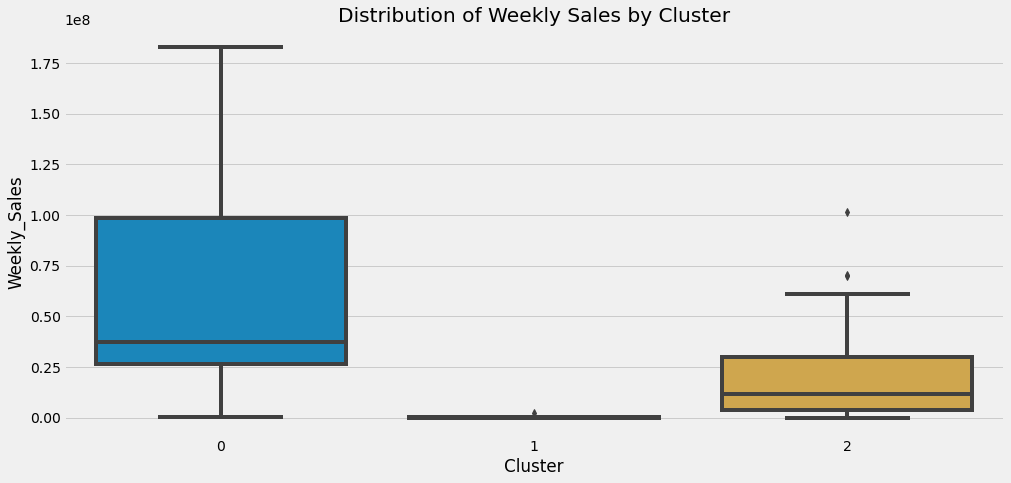

In [127]:
# Visualization for the distribution of Weekly Sales across clusters
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 7))
sns.boxplot(x='Cluster', y='Weekly_Sales', data=df_clustering_depts)
plt.title('Distribution of Weekly Sales by Cluster')
plt.show()

In [128]:
cluster_summary = df_clustering_depts.drop("Dept", axis=1).groupby('Cluster').mean().reset_index()

In [129]:
cluster_summary

,Cluster,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Total_MarkDown
0,0,6.078312e+07,60.248253,3.657171,174.782747,7.423268,18184.583262
1,1,5.724148e+05,48.359763,3.574142,153.249941,8.481594,26283.013972
2,2,2.018596e+07,59.325891,3.664871,173.940691,7.386162,19215.797236


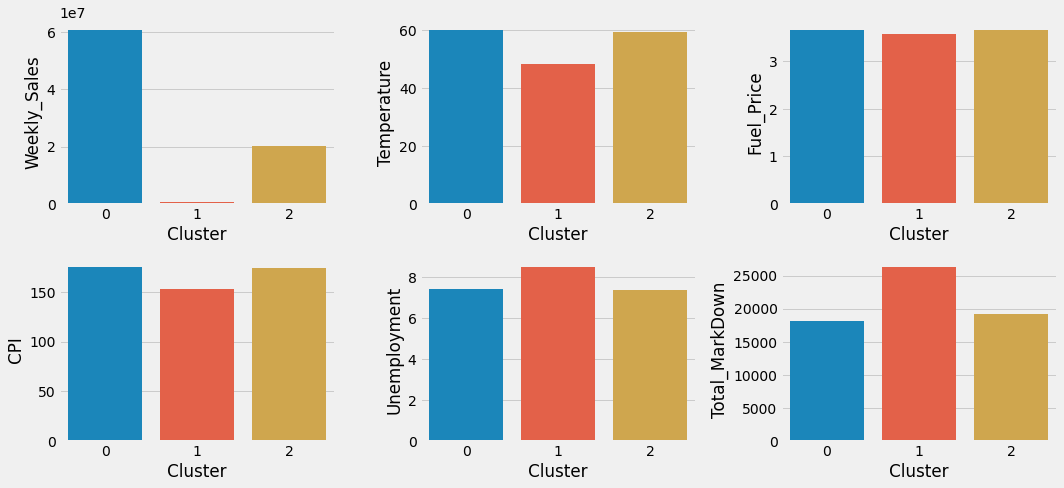

In [130]:
# Create a list of the features to be plotted along with their respective titles and y-labels
features = [
    ('Weekly_Sales', 'Average Weekly Sales'),
    ('Temperature', 'Average Temperature'),
    ('Fuel_Price', 'Average Fuel Price'),
    ('CPI', 'Average CPI'),
    ('Unemployment', 'Average Unemployment'), 
    ("Total_MarkDown",'Average Markdowns')
]
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 7))
# Loop through the features list and plot each feature in a subplot
for i, (feature, ylabel) in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x='Cluster', y=feature, data=cluster_summary)
    plt.xlabel('Cluster')

plt.tight_layout()
plt.show()

In [134]:
details = {}
for i in range(3):
    details[str(i)] = {}
    details[str(i)]["Depts"] = df_clustering_depts[df_clustering_depts["Cluster"] == i]["Dept"].unique()
    details[str(i)]["No. of Depts"] = df_clustering_depts[df_clustering_depts["Cluster"] == i]["Dept"].nunique()
details["Total_stores"] = df_clustering_depts["Dept"].nunique()

In [135]:
pprint(details)

{'0': {'Depts': array([38, 40, 67, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99], dtype=int64),
       'No. of Depts': 22},
 '1': {'Depts': array([43, 65, 77, 78], dtype=int64), 'No. of Depts': 4},
 '2': {'Depts': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56,
       58, 59, 60, 71], dtype=int64),
       'No. of Depts': 55},
 'Total_stores': 81}
